# FCN图像语义分割

全卷积网络（Fully Convolutional Networks，FCN）是UC Berkeley的Jonathan Long等人于2015年在Fully Convolutional Networks for Semantic Segmentation<sup>[1]</sup>一文中提出的用于图像语义分割的一种框架。

FCN是首个端到端（end to end）进行像素级（pixel level）预测的全卷积网络。

![fcn-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_1.png)

## 语义分割

在具体介绍FCN之前，首先介绍何为语义分割：

图像语义分割（semantic segmentation）是图像处理和机器视觉技术中关于图像理解的重要一环，AI领域中一个重要分支，常被应用于人脸识别、物体检测、医学影像、卫星图像分析、自动驾驶感知等领域。

语义分割的目的是对图像中每个像素点进行分类。与普通的分类任务只输出某个类别不同，语义分割任务输出与输入大小相同的图像，输出图像的每个像素对应了输入图像每个像素的类别。语义在图像领域指的是图像的内容，对图片意思的理解，下图是一些语义分割的实例：

![fcn-2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_2.png)

## 模型简介

FCN主要用于图像分割领域，是一种端到端的分割方法，是深度学习应用在图像语义分割的开山之作。通过进行像素级的预测直接得出与原图大小相等的label map。因FCN丢弃全连接层替换为全卷积层，网络所有层均为卷积层，故称为全卷积网络。

全卷积神经网络主要使用以下三种技术：

1. 卷积化（Convolutional）

    使用VGG-16作为FCN的backbone。VGG-16的输入为224*224的RGB图像，输出为1000个预测值。VGG-16只能接受固定大小的输入，丢弃了空间坐标，产生非空间输出。VGG-16中共有三个全连接层，全连接层也可视为带有覆盖整个区域的卷积。将全连接层转换为卷积层能使网络输出由一维非空间输出变为二维矩阵，利用输出能生成输入图片映射的heatmap。

   ![fcn-3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_3.png)

2. 上采样（Upsample）

    在卷积过程的卷积操作和池化操作会使得特征图的尺寸变小，为得到原图的大小的稠密图像预测，需要对得到的特征图进行上采样操作。使用双线性插值的参数来初始化上采样逆卷积的参数，后通过反向传播来学习非线性上采样。在网络中执行上采样，以通过像素损失的反向传播进行端到端的学习。

    ![fcn-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_4.png)

3. 跳跃结构（Skip Layer）

    利用上采样技巧对最后一层的特征图进行上采样得到原图大小的分割是步长为32像素的预测，称之为FCN-32s。由于最后一层的特征图太小，损失过多细节，采用skips结构将更具有全局信息的最后一层预测和更浅层的预测结合，使预测结果获取更多的局部细节。将底层（stride 32）的预测（FCN-32s）进行2倍的上采样得到原尺寸的图像，并与从pool4层（stride 16）进行的预测融合起来（相加），这一部分的网络被称为FCN-16s。随后将这一部分的预测再进行一次2倍的上采样并与从pool3层得到的预测融合起来，这一部分的网络被称为FCN-8s。 Skips结构将深层的全局信息与浅层的局部信息相结合。

    ![fcn-5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_5.png)

## 网络特点

1. 不含全连接层(fc)的全卷积(fully conv)网络，可适应任意尺寸输入。  
2. 增大数据尺寸的反卷积(deconv)层，能够输出精细的结果。  
3. 结合不同深度层结果的跳级(skip)结构，同时确保鲁棒性和精确性。


## 环境准备

开发者拿到香橙派开发板后，首先需要进行硬件资源确认，镜像烧录及CANN和MindSpore版本的升级，才可运行该案例，具体如下：

- 硬件： 香橙派AIpro 16G 8-12T开发板
- 镜像： 香橙派官网ubuntu镜像
- CANN：8.0.RC3.alpha002
- MindSpore： 2.4.10

### 镜像烧录

运行该案例需要烧录香橙派官网ubuntu镜像，烧录流程参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--镜像烧录](https://www.mindspore.cn/docs/zh-CN/r2.4.10/orange_pi/environment_setup.html#1-%E9%95%9C%E5%83%8F%E7%83%A7%E5%BD%95%E4%BB%A5windows%E7%B3%BB%E7%BB%9F%E4%B8%BA%E4%BE%8B)章节。

### CANN升级

CANN升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--CANN升级](https://www.mindspore.cn/docs/zh-CN/r2.4.10/orange_pi/environment_setup.html#3-cann%E5%8D%87%E7%BA%A7)章节。

### MindSpore升级

MindSpore升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--MindSpore升级](https://www.mindspore.cn/docs/zh-CN/r2.4.10/orange_pi/environment_setup.html#4-mindspore%E5%8D%87%E7%BA%A7)章节。

## 设置运行环境
 由于资源限制原因，需要开启性能优化模式，具体需要设置如下参数：

由于资源限制，需开启性能优化模式，具体设置如下参数：

 max_device_memory="2GB" : 设置设备可用的最大内存为2GB。

 mode=mindspore.GRAPH_MODE : 表示在GRAPH_MODE模式中运行。

 device_target="Ascend" : 表示待运行的目标设备为Ascend。

 jit_config={"jit_level":"O2"} : 编译优化级别开启极致性能优化，使用下沉的执行方式。

 ascend_config={"precision_mode":"allow_mix_precision"} : 自动混合精度，自动将部分算子的精度降低到float16或bfloat16。

In [ ]:
import mindspore
mindspore.set_context(max_device_memory="2GB", mode=mindspore.GRAPH_MODE, device_target="Ascend", jit_config={"jit_level":"O2"}, ascend_config={"precision_mode":"allow_mix_precision"})

## 数据处理

In [ ]:
#install download

!pip install download

In [1]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/dataset_fcn8s.tar"

download(url, "./dataset", kind="tar", replace=True)


file_sizes: 100%|████████████████████████████| 563M/563M [00:44<00:00, 12.6MB/s]
Extracting tar file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

### 数据加载和预处理

由于PASCAL VOC 2012数据集中图像的分辨率大多不一致，无法放在一个tensor中，故输入前需做标准化处理。将PASCAL VOC 2012数据集与SDB数据集进行混合。

In [2]:
import numpy as np
import cv2
import mindspore.dataset as ds

class SegDataset:
    def __init__(self,
                 image_mean,  # 图像均值，用于归一化处理
                 image_std,   # 图像标准差，用于归一化处理
                 data_file='', # 数据集文件路径
                 batch_size=32, # 批次大小
                 crop_size=512, # 裁剪尺寸
                 max_scale=2.0, # 随机缩放的最大比例
                 min_scale=0.5, # 随机缩放的最小比例
                 ignore_label=255, # 标签中被忽略的标签值
                 num_classes=21, # 分类数量
                 num_readers=2,  # 并行读取数据的线程数
                 num_parallel_calls=4):  # 数据预处理并行调用的数量

        self.data_file = data_file
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.image_mean = np.array(image_mean, dtype=np.float32)
        self.image_std = np.array(image_std, dtype=np.float32)
        self.max_scale = max_scale
        self.min_scale = min_scale
        self.ignore_label = ignore_label
        self.num_classes = num_classes
        self.num_readers = num_readers
        self.num_parallel_calls = num_parallel_calls
        max_scale > min_scale

    def preprocess_dataset(self, image, label):
        """
        对图像和标签进行预处理：解码、随机缩放、归一化、填充、随机裁剪、水平翻转等。
        """
        # 解码图像和标签
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
         # 随机缩放
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        # 归一化
        image_out = (image_out - self.image_mean) / self.image_std

         # 填充到至少为crop_size大小
        out_h, out_w = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = out_h - new_h, out_w - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        # 随机裁剪
        offset_h = np.random.randint(0, out_h - self.crop_size + 1)
        offset_w = np.random.randint(0, out_w - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]
        # 随机水平翻转
        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]
        # 调整维度顺序以适应深度学习框架的要求，并复制数据以确保内存连续
        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        label_out = label_out.astype("int32")
        return image_out, label_out

    def get_dataset(self):
        """
        获取预处理后的数据集。
        """
        ds.config.set_numa_enable(True) # 启用NUMA配置（如果支持的话）
        dataset = ds.MindDataset(self.data_file, columns_list=["data", "label"],
                                 shuffle=True, num_parallel_workers=self.num_readers)
         # 应用预处理操作
        transforms_list = self.preprocess_dataset
        dataset = dataset.map(operations=transforms_list, input_columns=["data", "label"],
                              output_columns=["data", "label"],
                              num_parallel_workers=self.num_parallel_calls)
        dataset = dataset.shuffle(buffer_size=self.batch_size * 10)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset


# 定义创建数据集的参数
IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "dataset/dataset_fcn8s/mindname.mindrecord"

# 定义模型训练参数
eval_batch_size = 1
crop_size = 512
min_scale = 0.5
max_scale = 2.0
ignore_label = 255
num_classes = 21

# 实例化Dataset
dataset_eval = SegDataset(image_mean=IMAGE_MEAN,
                     image_std=IMAGE_STD,
                     data_file=DATA_FILE,
                     batch_size=eval_batch_size,
                     crop_size=crop_size,
                     max_scale=max_scale,
                     min_scale=min_scale,
                     ignore_label=ignore_label,
                     num_classes=num_classes,
                     num_readers=2,
                     num_parallel_calls=4)

dataset_eval = dataset_eval.get_dataset()

[WARNING] ME(10263:281473386844176,MainProcess):2024-09-06-09:42:09.638.024 [mindspore/run_check/_check_version.py:357] MindSpore version 2.2.14 and Ascend AI software package (Ascend Data Center Solution)version 7.0 does not match, the version of software package expect one of ['7.1']. Please refer to the match info on: https://www.mindspore.cn/install
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
[WARNING] ME(10263:281473386844176,MainProcess):2024-09-06-09:42:12.682.030 [mindspore/run_check/_check_version.py:375] MindSpore version 2.2.14 and "te" wheel pack

### 数据集可视化

运行以下代码观察载入的数据集图片（数据处理过程中已做归一化处理）。

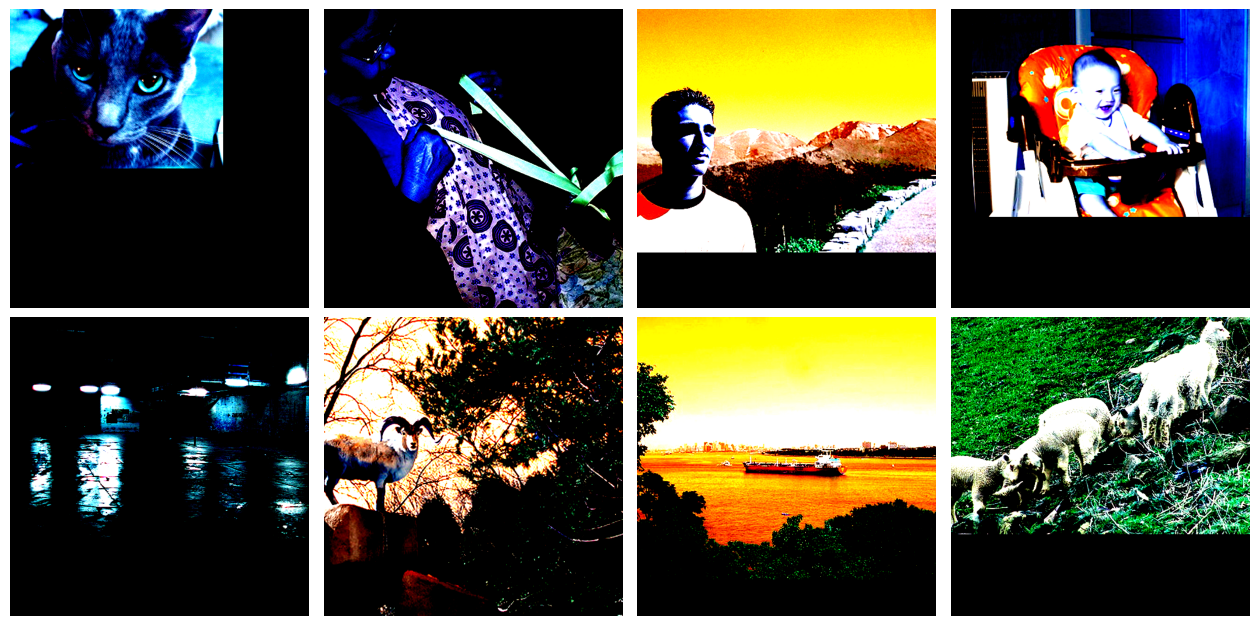

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# 对训练集中的数据进行展示
for i in range(1, 9):
    plt.subplot(2, 4, i)
    show_data = next(dataset_eval.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    show_images = np.clip(show_images, 0, 1)
# 将图片转换HWC格式后进行展示
    plt.imshow(show_images[0].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

## 网络构建

### 网络流程

FCN网络的流程如下图所示：

1. 输入图像image，经过pool1池化后，尺寸变为原始尺寸的1/2。
2. 经过pool2池化，尺寸变为原始尺寸的1/4。
3. 接着经过pool3、pool4、pool5池化，大小分别变为原始尺寸的1/8、1/16、1/32。
4. 经过conv6-7卷积，输出的尺寸依然是原图的1/32。
5. FCN-32s是最后使用反卷积，使得输出图像大小与输入图像相同。
6. FCN-16s是将conv7的输出进行反卷积，使其尺寸扩大两倍至原图的1/16，并将其与pool4输出的特征图进行融合，后通过反卷积扩大到原始尺寸。
7. FCN-8s是将conv7的输出进行反卷积扩大4倍，将pool4输出的特征图反卷积扩大2倍，并将pool3输出特征图拿出，三者融合后通反卷积扩大到原始尺寸。

![fcn-6](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.1/tutorials/application/source_zh_cn/cv/images/fcn_6.png)

使用以下代码构建FCN-8s网络。

In [5]:
import mindspore.nn as nn

class FCN8s(nn.Cell):
    def __init__(self, n_class):
        """
        初始化FCN8s模型，设置类别数量并定义所有层。
        
        参数:
            n_class (int): 分割类别的数量。
        """
        super().__init__()
        self.n_class = n_class
        # 卷积块1：两个3x3卷积层和BN层，后接最大池化层
        self.conv1 = nn.SequentialCell(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积块2：两个3x3卷积层和BN层，后接最大池化层
        self.conv2 = nn.SequentialCell(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积块3：三个3x3卷积层和BN层，后接最大池化层
        self.conv3 = nn.SequentialCell(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积块4：三个3x3卷积层和BN层，后接最大池化层
        self.conv4 = nn.SequentialCell(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积块5：三个3x3卷积层和BN层，后接最大池化层
        self.conv5 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全卷积层6：7x7卷积层和BN层，用于代替全连接层
        self.conv6 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=4096,
                      kernel_size=7, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        # 全卷积层7：1x1卷积层和BN层，用于代替全连接层
        self.conv7 = nn.SequentialCell(
            nn.Conv2d(in_channels=4096, out_channels=4096,
                      kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        # 产生分数图的层
        self.score_fr = nn.Conv2d(in_channels=4096, out_channels=self.n_class,
                                  kernel_size=1, weight_init='xavier_uniform')
        # 反卷积层（上采样），用于将特征图恢复到原始输入大小
        self.upscore2 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool4 = nn.Conv2d(in_channels=512, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore_pool4 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                                kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool3 = nn.Conv2d(in_channels=256, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore8 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=16, stride=8, weight_init='xavier_uniform')

    def construct(self, x):
        """
        前向传播函数，定义了数据流经网络时的操作。
        """
        # 通过卷积块1-5进行前向传播
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)
        x5 = self.conv5(p4)
        p5 = self.pool5(x5)
         # 通过全卷积层6和7进行前向传播
        x6 = self.conv6(p5)
        x7 = self.conv7(x6)
         # 生成分数图并进行2倍上采样
        sf = self.score_fr(x7)
        u2 = self.upscore2(sf)
         # 将p4层的特征与上采样的分数图相加，并再次上采样2倍
        s4 = self.score_pool4(p4)
        f4 = s4 + u2
        u4 = self.upscore_pool4(f4)
         # 将p3层的特征与上一次上采样的结果相加，并最终上采样8倍以恢复输入图像尺寸
        s3 = self.score_pool3(p3)
        f3 = s3 + u4
        out = self.upscore8(f3)
        return out

## 权重加载
使用MindSpore提供的Checkpoint加载和网络权重加载接口：1.将保存的模型Checkpoint加载到内存中；2.将Checkpoint加载至模型。

> `load_param_into_net`接口会返回模型中没有和Checkpoint匹配的权重名，正确匹配时返回空列表。

In [ ]:
from download import download
from mindspore import load_checkpoint, load_param_into_net

# 下载已训练好的权重文件
url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-online-infer/04-FCN/FCN8s.ckpt"
download(url, "FCN8s.ckpt", replace=True)

net = FCN8s(n_class=num_classes)
ckpt_file = "FCN8s.ckpt"
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)

## 模型推理

下文中使用已训练好的权重文件对模型推理结果进行展示。

In [6]:
import cv2
import matplotlib.pyplot as plt


# 推理效果展示(上方为输入图片，下方为推理效果图片)
plt.figure(figsize=(8, 5))
for i in range(1, 5):
    plt.subplot(2, 4, i)
    show_data = next(dataset_eval.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    show_images = np.clip(show_images, 0, 1)
    # 将图片转换HWC格式后进行展示
    plt.imshow(show_images[0].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    # 语义分割后效果
    plt.subplot(2, 4, i + 4)
    res = net(show_data["data"]).asnumpy().argmax(axis=1)
    plt.imshow(res[0])
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.show()

本案例已同步上线[GitHub仓](https://github.com/mindspore-courses/orange-pi-mindspore/tree/master/Online/04-FCN)，更多案例开发亦可参考该仓库

本案例运行所需环境：

- 硬件： 香橙派AIpro 16G 8-12T开发板
- 镜像： 香橙派官网ubuntu镜像
- CANN：8.0.RC3.alpha002
- MindSpore： 2.4.10